## 09 - Calculating Plate Tectonic Stats

In this notebook, we demonstrate how GPlately can be combined with Tectonic Tools functionalities for calculating plate tectonic stats such as the:

- Total length of all mid-ocean ridges (km)
- Mean ridge spreading velocity (spreading rate) (cm/yr)
- Mean ridge spreading velocity standard deviation (cm/yr)
- Crustal surface area produced over 1 yr at ridges (km^2/yr)
- Total length of all subduction zones (km)
- Mean subduction velocity (convergence rate) (cm/yr)
- Mean subduction velocity standard deviation (cm/yr)
- Crustal surface area subducted by trenches over 1 yr (km^2/yr)
- Length of all transform boundaries (km)

for two different plate models: Müller et al. (2016) and Müller et al. (2019).

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import ptt

Load in the plate model data using `DataServer`:

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

gdownload2 = gplately.download.DataServer("Muller2016")
rotation_model2, topology_features2, static_polygons2 = gdownload2.get_plate_reconstruction_files()
model2 = gplately.PlateReconstruction(rotation_model2, topology_features2, static_polygons2)

In [3]:
time = 0 #Ma
coastlines, continents, COBs = gdownload.get_topology_geometries()
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

coastlines2, continents2, COBs2 = gdownload2.get_topology_geometries()
gplot2 = gplately.plot.PlotTopologies(model2, time, coastlines2, continents2, COBs2)

No continents in Muller2016.
No continent-ocean boundaries in Muller2016.


Create a function to calculate plate tectonics stats using GPlately and Plate Tectonic Tools:

In [4]:
# Function to obtain plate tectonic stats at a specified reconstruction time
def get_plate_tectonic_stats(model, reconstruction_time):
    total_mor_length = []
    total_sz_length = []

    # Get boundary lengths
    gplot = gplately.plot.PlotTopologies(model, reconstruction_time)
    boundary_features = [
        gplot.ridge_transforms, 
        gplot.ridges, 
        gplot.transforms, 
        gplot.trenches, 
        gplot.trench_left, 
        gplot.trench_right, 
        gplot.other
    ]
    len_ridge_transform, len_ridge, len_transform, len_subd, len_subd_l, len_subd_r, len_other =  \
        ptt.resolve_topologies.find_total_boundary_length_in_kms(*boundary_features)

    # Calculate ridge stats
    ridge_data = model.tesselate_mid_ocean_ridges(reconstruction_time, ignore_warnings=True)
    ridge_data = ridge_data[ridge_data[:,2] >= 0]
    ridge_lon, ridge_lat = ridge_data[:,0], ridge_data[:,1]
    ridge_vel = ridge_data[:,2]*1e-2 # m/yr
    ridge_len = []
    for i, segment in enumerate(ridge_data[:,3]):
        ridge_len.append(np.radians(segment) * gplately.tools.geocentric_radius((ridge_data[i,1])))

    # Mean ridge spreading velocity, standard deviation, and ridge surface area
    ridge_vel_mean, ridge_vel_std = np.mean(ridge_vel), np.std(ridge_vel)
    ridge_surface_area = np.sum(ridge_vel * ridge_len)

    # Calculate subduction convergence stats
    subduction_data = model.tesselate_subduction_zones(reconstruction_time, ignore_warnings=True)
    subduction_lon, subduction_lat = subduction_data[:,0], subduction_data[:,1]
    subduction_len = []
    for i, segment in enumerate(subduction_data[:,6]):
        subduction_len.append(np.radians(segment) * gplately.tools.geocentric_radius(subduction_data[i,1]))

    # protect against "negative" subduction
    subduction_data[:,2] = np.clip(subduction_data[:,2], 0.0, 1e99)
    subduction_vel = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
    subd_vel_mean, subd_vel_std = np.mean(subduction_vel), np.std(subduction_vel)

    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_vel * subduction_len)

    # Format units - lengths are already in km
    ridge_vel_mean     = ridge_vel_mean * 100  # m/yr to cm/yr
    ridge_vel_std      = ridge_vel_std * 100  # m/yr to cm/yr
    ridge_surface_area = ridge_surface_area * 1e-6 # m^2/a to km^2/a
    subd_vel_mean      = subd_vel_mean * 100  # m/yr to cm/yr
    subd_vel_std       = subd_vel_std * 100  # m/yr to cm/yr
    subd_surface_area  = subd_surface_area * 1e-6 # m^2 /a to km^2/a

    # For this notebook, let's only return the total lengths of ridges and trenches.
    total_mor_length.append(len_ridge)
    total_sz_length.append(len_subd)
    lists = len_ridge, len_subd
    #print("Time: {}, MOR: {}, SZ: {}".format(reconstruction_time, len_ridge, len_subd))
    
    return lists


## Visualising plate tectonic stats
Let's plot the total global mid-ocean ridge and subduction zone lengths during each Ma for both the Müller et al. 2016 and 2019 plate models.

In [5]:
# Müller et al. 2019
time_array = np.arange(0,231)

m2019_mor_length = []
m2019_sz_length = []
for time in time_array:
    mor_length, sz_length = get_plate_tectonic_stats(model, time)
    m2019_mor_length.append(mor_length)
    m2019_sz_length.append(sz_length)

In [6]:
# Müller et al. 2016
time_array = np.arange(0,231)

m2016_mor_length = []
m2016_sz_length = []
for time in time_array:
    mor_length, sz_length = get_plate_tectonic_stats(model2, time)
    m2016_mor_length.append(mor_length)
    m2016_sz_length.append(sz_length)

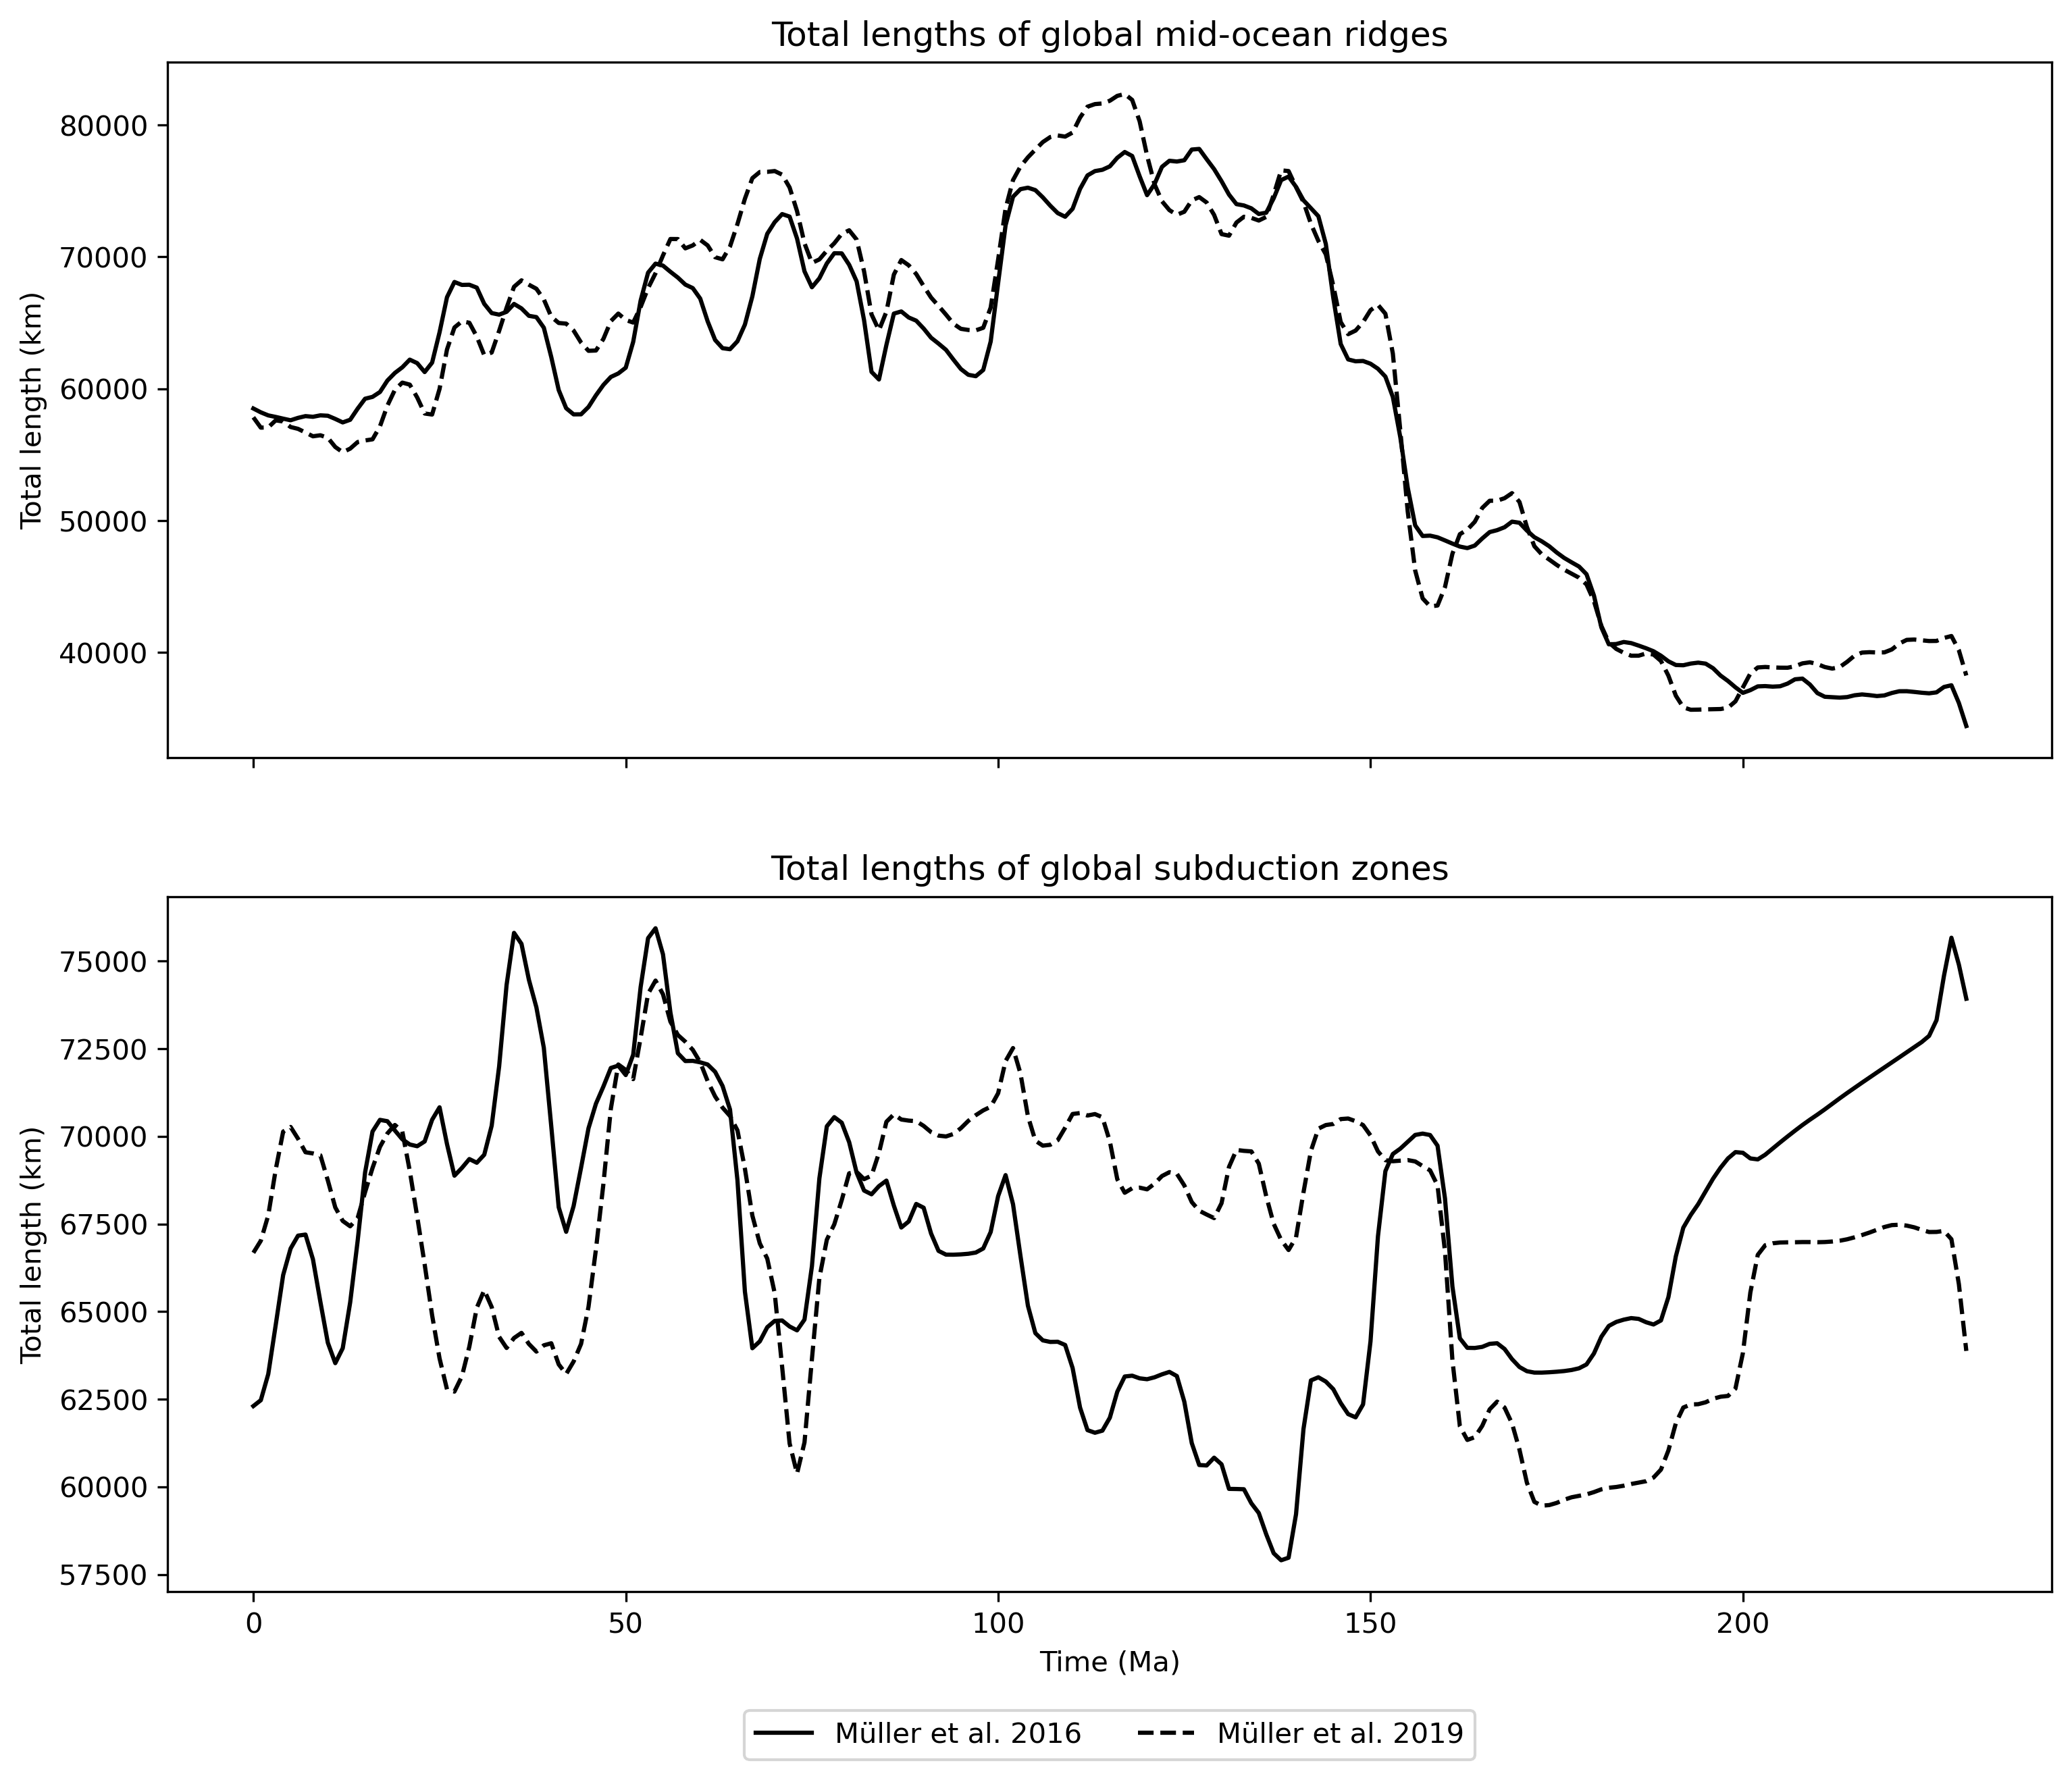

In [7]:
# Plot these data using a Gaussian filter
from scipy.ndimage import gaussian_filter
m2016_mor_length_smoothed = gaussian_filter(m2016_mor_length, sigma=1)
m2019_mor_length_smoothed = gaussian_filter(m2019_mor_length, sigma=1)
m2016_sz_length_smoothed = gaussian_filter(m2016_sz_length, sigma=1)
m2019_sz_length_smoothed = gaussian_filter(m2019_sz_length, sigma=1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), dpi=300, sharex=True)
ax1.plot(time_array, m2016_mor_length_smoothed, color="k")
ax1.plot(time_array, m2019_mor_length_smoothed, linestyle="--", color="k")
ax1.set_title('Total lengths of global mid-ocean ridges')
ax1.set_ylabel("Total length (km)")

ax2.plot(time_array, m2016_sz_length_smoothed, color="k", label="Müller et al. 2016")
ax2.plot(time_array, m2019_sz_length_smoothed, linestyle="--", color="k", label="Müller et al. 2019")
ax2.set_title('Total lengths of global subduction zones')
ax2.set_xlabel("Time (Ma)")
ax2.set_ylabel("Total length (km)")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.show()